<a href="https://colab.research.google.com/github/lecture-series-2021/lecture2/blob/main/lecture2_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 2: Image Formation and Camera Geometry
# Setup

In [9]:
!pip install ipywidgets transforms3d

In [10]:
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import transforms3d.euler as txe  

In [11]:
class Camera:
  """
  Simple class that collects all camera parameters
  """
  def __init__(self,
               fx=500.0, fy=500.0, cx=320.0, cy=240,
               tx=0.0, ty=0.0, tz=0.0,
               rx_deg=0.0, ry_deg=0.0, rz_deg=0.0):
    self.W = 640
    self.H = 480

    # intrinsics
    self.fx = fx
    self.fy = fy
    self.cx = cx
    self.cy = cy
    
    # extrinsics
    self.tx = tx
    self.ty = ty
    self.tz = tz
    self.rx_deg = rx_deg
    self.ry_deg = ry_deg
    self.rz_deg = rz_deg

  @property
  def K(self):
    """
    Returns: 3x3 intrinsics matrix
    """
    return np.array([
      [self.fx, 0.0, self.cx],
      [0.0, self.fy, self.cy],
      [0.0, 0.0, 1.0]
    ])

  @property
  def R(self):
    """
    Returns: 3x3 rotation matrix part of camera extrinsics matrix
    """
    return txe.euler2mat(np.deg2rad(self.rx_deg), np.deg2rad(self.ry_deg),
                         np.deg2rad(self.rz_deg))

  @property
  def t(self):
    """
    Returns: 3-element translation part of camera extrinsics matrix
    """
    return np.array([self.tx, self.ty, self.tz])

  @property
  def wTc(self):
    """
    Returns: 4x4 camera extrinsics matrix. Pose of camera (c) w.r.t. world (w)
    """
    M = np.eye(4)
    M[:3, :3] = self.R
    M[:3,  3] = self.t
    return M


def transform_points(aTb, bX):
  """
  Inputs:
  - bX: Nx3 matrix of N 3D points in "b" coordinate system
  - aTb: 4x4 matrix representing the pose of "b" coordinate system in "a"
  coordinate system
  Returns:
  - aX: Nx3 matrix of N 3D points in "a" coordinate system, transformed using
  aTb
  """
  bX = np.vstack((bX.T, np.ones(len(bX))))
  aX = aTb @ bX
  return aX[:3].T


def plottable_cube(cube):
  return np.vstack((
      cube[:4],
      cube[0],
      cube[4:8],
      cube[4],
      cube[5],
      cube[1],
      cube[2],
      cube[6],
      cube[7],
      cube[3],
  ))

#Get Data

In [12]:
# Create artifical cube vertex data
s = 0.2
plane = np.array([[-s, -s, 0], [s, -s, 0], [s, s, 0], [-s, s, 0]])
cube = np.vstack((plane-np.array([0, 0, s]), plane+np.array([0, 0, s])))
print('cube\n', cube)
oX = plottable_cube(cube)
wTo = np.eye(4)
wTo[2, 3] = 1.0
wX = transform_points(wTo, oX)

cube
 [[-0.2 -0.2 -0.2]
 [ 0.2 -0.2 -0.2]
 [ 0.2  0.2 -0.2]
 [-0.2  0.2 -0.2]
 [-0.2 -0.2  0.2]
 [ 0.2 -0.2  0.2]
 [ 0.2  0.2  0.2]
 [-0.2  0.2  0.2]]


#Homework

In [13]:
# Fill out the following function
def project1(wX, cam: Camera):
  """
  Projection function.
  ** Inputs:
  - wX: Nx3 matrix of 3D points in the world coordinate system "w"
  - cam: Camera object
  ** Returns:
  - Mx2 matrix of 2D projections of 3D points which are *in front* of the camera.
  Each row represents 1 point, in (x, y) format
  3D points behind the camera should be ignored
  """
  # cx = ...
  # return cx

## Solution
Click the black arrow to the left of "Solution" to peek at the solution

In [14]:
def project_solution(wX, cam: Camera):
  """
  Projection function.
  ** Inputs:
  - wX: Nx3 matrix of 3D points in the world coordinate system "w"
  - cam: Camera object
  ** Returns:
  - Mx2 matrix of 2D projections of 3D points which are *in front* of the camera.
  Each row represents 1 point, in (x, y) format
  3D points behind the camera should be ignored
  """
  # make homogeneous
  wX = np.vstack((wX.T, np.ones(len(wX))))
  # transform from world to camera coordinate system
  cX = np.linalg.inv(cam.wTc) @ wX
  # make in-homogeneous
  cX = cX[:3]
  # keep only points that lie in front of the camera (positive Z coordinate)
  keep_idx = cX[2] >= 0
  cX = cX[:, keep_idx]
  # project using intrinsics
  cx = cam.K @ cX
  # convert from homogeneous to pixel coorinates
  cx = cx[:2] / cx[2]
  return cx.T

#Show

In [15]:
# Functions for drawing the projected cube
def draw_from_cam(cam: Camera):
  cx = project(wX, cam)
  _, ax = plt.subplots()
  ax.scatter(cx[:5, 0], cx[:5, 1], c='black', marker='o')
  ax.scatter(cx[5:10, 0], cx[5:10, 1], c='black', marker='x')
  lines = np.dstack((cx[:-1], cx[1:]))
  colors = [(1, 0, 0), (0, 1, 0), (1, 0, 0), (0, 1, 0)]
  colors += [(0, 0, 1)]
  colors += [(1, 0, 0), (0, 1, 0), (1, 0, 0), (0, 1, 0)]
  colors += [(1, 0, 0), (0, 0, 1), (0, 1, 0), (0, 0, 1), (1, 0, 0), (0, 0, 1)]
  for line, color in zip(lines, colors):
    ax.plot(line[0, :], line[1, :], c=color)
  ax.set_xlim(0, cam.W-1)
  ax.set_ylim(cam.H-1, 0)
  plt.show()

def draw_from_params(fx, fy, cx, cy, tx, ty, tz, rx_deg, ry_deg, rz_deg):
  cam = Camera(fx, fy, cx, cy, tx, ty, tz, rx_deg, ry_deg, rz_deg)
  return draw_from_cam(cam)

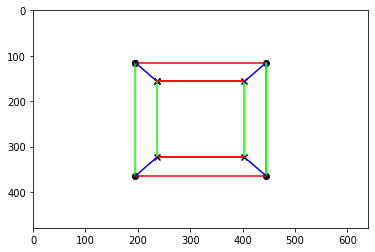

In [16]:
draw_from_cam(Camera())

In [17]:
w = widgets.interactive(draw_from_params,
      fx=widgets.FloatSlider(value=500.0, min=250.0, max=750.0, continuous_update=False),
      fy=widgets.FloatSlider(value=500.0, min=250.0, max=750.0, continuous_update=False),
      cx=widgets.FloatSlider(value=320.0, min=0.0, max=639.0, continuous_update=False),
      cy=widgets.FloatSlider(value=240.0, min=0.0, max=479.0, continuous_update=False),
      tx=widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, continuous_update=False),
      ty=widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, continuous_update=False),
      tz=widgets.FloatSlider(value=0.0, min=-2.0, max=0.75, continuous_update=False),
      rx_deg=widgets.FloatSlider(value=0.0, min=-90.0, max=90.0, continuous_update=False),
      ry_deg=widgets.FloatSlider(value=0.0, min=-90.0, max=90.0, continuous_update=False),
      rz_deg=widgets.FloatSlider(value=0.0, min=-90.0, max=90.0, continuous_update=False),
    )
w

interactive(children=(FloatSlider(value=500.0, continuous_update=False, description='fx', max=750.0, min=250.0…